In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import jax
from graphcast import graphcast, checkpoint

In [9]:
from p1stackedtraining import P1Emulator

In [3]:
from graphufs.datasets import Dataset
from graphufs.utils import get_channel_index

In [32]:
import graphufs
plt.style.use("graphufs.plotstyle")

In [10]:
p1 = P1Emulator()

In [11]:
tds = Dataset(p1, mode="training")

In [12]:
xinputs, xtargets, _ = tds.get_xarrays(0)

In [13]:
xtargets

<xarray.Dataset> Size: 24MB
Dimensions:     (batch: 1, time: 1, level: 13, lat: 192, lon: 384)
Coordinates:
  * batch       (batch) int64 8B 0
  * lon         (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * lat         (lat) float64 2kB 89.82 88.89 87.95 ... -87.25 -88.18 -89.12
  * level       (level) float32 52B 47.81 97.82 145.7 ... 847.8 921.9 998.8
    datetime    (time) datetime64[ns] 8B 1994-01-01
  * time        (time) timedelta64[ns] 8B 03:00:00
Data variables:
    delz        (batch, time, level, lat, lon) float32 4MB dask.array<chunksize=(1, 1, 13, 192, 384), meta=np.ndarray>
    tmp2m       (batch, time, lat, lon) float32 295kB dask.array<chunksize=(1, 1, 192, 384), meta=np.ndarray>
    pressfc     (batch, time, lat, lon) float32 295kB dask.array<chunksize=(1, 1, 192, 384), meta=np.ndarray>
    ugrd10m     (batch, time, lat, lon) float32 295kB dask.array<chunksize=(1, 1, 192, 384), meta=np.ndarray>
    vgrd10m     (batch, time, lat, lon) float32 295kB dask.array<chunksize=(1, 1, 192, 384), meta=np.ndarray>
    prateb_ave  (batch, time, lat, lon) float32 295kB dask.array<chunksize=(1, 1, 192, 384), meta=np.ndarray>
    tmp         (batch, time, level, lat, lon) float32 4MB dask.array<chunksize=(1, 1, 13, 192, 384), meta=np.ndarray>
    ugrd        (batch, time, level, lat, lon) float32 4MB dask.array<chunksize=(1, 1, 13, 192, 384), meta=np.ndarray>
    vgrd        (batch, time, level, lat, lon) float32 4MB dask.array<chunksize=(1, 1, 13, 192, 384), meta=np.ndarray>
    dzdt        (batch, time, level, lat, lon) float32 4MB dask.array<chunksize=(1, 1, 13, 192, 384), meta=np.ndarray>
    spfh        (batch, time, level, lat, lon) float32 4MB dask.array<chunksize=(1, 1, 13, 192, 384), meta=np.ndarray>

In [15]:
tidx = get_channel_index(xtargets)

In [16]:
tidx

{0: {'varname': 'delz', 'time': 0, 'level': 0},
 1: {'varname': 'delz', 'time': 0, 'level': 1},
 2: {'varname': 'delz', 'time': 0, 'level': 2},
 3: {'varname': 'delz', 'time': 0, 'level': 3},
 4: {'varname': 'delz', 'time': 0, 'level': 4},
 5: {'varname': 'delz', 'time': 0, 'level': 5},
 6: {'varname': 'delz', 'time': 0, 'level': 6},
 7: {'varname': 'delz', 'time': 0, 'level': 7},
 8: {'varname': 'delz', 'time': 0, 'level': 8},
 9: {'varname': 'delz', 'time': 0, 'level': 9},
 10: {'varname': 'delz', 'time': 0, 'level': 10},
 11: {'varname': 'delz', 'time': 0, 'level': 11},
 12: {'varname': 'delz', 'time': 0, 'level': 12},
 13: {'varname': 'dzdt', 'time': 0, 'level': 0},
 14: {'varname': 'dzdt', 'time': 0, 'level': 1},
 15: {'varname': 'dzdt', 'time': 0, 'level': 2},
 16: {'varname': 'dzdt', 'time': 0, 'level': 3},
 17: {'varname': 'dzdt', 'time': 0, 'level': 4},
 18: {'varname': 'dzdt', 'time': 0, 'level': 5},
 19: {'varname': 'dzdt', 'time': 0, 'level': 6},
 20: {'varname': 'dzdt', 't

In [17]:
ds = xr.load_dataset("results/v1/loss.nc")

In [3]:
ds

<xarray.Dataset> Size: 85MB
Dimensions:          (optim_step: 237400, epoch: 50, channels: 83)
Coordinates:
  * optim_step       (optim_step) int64 2MB 0 1 2 3 ... 237397 237398 237399
  * epoch            (epoch) int64 400B 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
  * channels         (channels) int64 664B 0 1 2 3 4 5 6 ... 77 78 79 80 81 82
Data variables:
    loss             (optim_step) float32 950kB 21.38 21.23 21.0 ... 1.364 1.373
    loss_by_channel  (optim_step, channels) float32 79MB 0.01127 ... 0.02624
    loss_avg         (epoch) float32 200B 4.091 2.522 2.247 ... 1.389 1.386
    loss_valid       (epoch) float32 200B 3.124 2.44 2.279 ... 1.519 1.518 1.517
    learning_rate    (optim_step) float32 950kB 0.0 1e-06 2e-06 ... 0.0 0.0 0.0
    epoch_label      (optim_step) float64 2MB 1.0 1.0 1.0 1.0 ... 50.0 50.0 50.0
Attributes:
    batch_size:  16

In [22]:
ds.loss.groupby(ds.epoch_label).mean().rename({"epoch_label": "epoch"})

<xarray.DataArray 'loss' (epoch: 50)> Size: 200B
array([4.09078  , 2.521941 , 2.2471864, 2.1188293, 2.0499897, 1.9997921,
       1.9640476, 1.9359745, 1.9128058, 1.8916731, 1.8755574, 1.8581753,
       1.8437458, 1.8272153, 1.8143445, 1.801235 , 1.7863257, 1.7747214,
       1.7615069, 1.7493626, 1.7371833, 1.7249695, 1.7110455, 1.7003714,
       1.6878717, 1.6753047, 1.6625903, 1.6501846, 1.6369334, 1.6242534,
       1.6111367, 1.5982957, 1.584972 , 1.5703748, 1.5565008, 1.542725 ,
       1.5286202, 1.5137967, 1.4992335, 1.4843392, 1.4700333, 1.4558514,
       1.442455 , 1.4299926, 1.418523 , 1.4084514, 1.4000784, 1.3934727,
       1.3889154, 1.3863922], dtype=float32)
Coordinates:
  * epoch    (epoch) float64 400B 1.0 2.0 3.0 4.0 5.0 ... 47.0 48.0 49.0 50.0
Attributes:
    long_name:  loss function value

In [27]:
from tqdm import tqdm

In [45]:
loss_by_var = {}
for cidx in tqdm(ds.channels.values):
    varname = tidx[cidx]["varname"]
    is3d = "level" in tidx[cidx]
    vweight = 1/13 if is3d else 1
    
    this_loss = ds["loss_by_channel"].sel(channels=cidx, drop=True)
    this_loss = this_loss.groupby(ds.epoch_label).mean().rename({"epoch_label": "epoch"})
    #this_loss *= vweight
    
    if varname not in loss_by_var:
        loss_by_var[varname] = this_loss
    else:
        loss_by_var[varname] += this_loss
        
vds = xr.Dataset(loss_by_var)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:07<00:00, 11.12it/s]


In [53]:
plt.style.use("fast")

[Text(0, 0.5, 'Loss')]

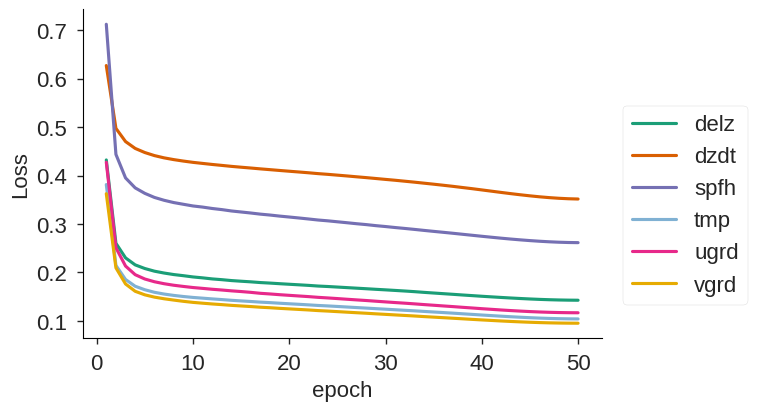

In [59]:
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)

v3d = [k for k in vds.data_vars if k not in ["pressfc", "tmp2m", "ugrd10m", "vgrd10m", "prateb_ave"]]
v2d = [k for k in vds.data_vars if k in ["pressfc", "tmp2m", "ugrd10m", "vgrd10m", "prateb_ave"]]

for key in v3d:
    vds[key].plot.line(
        ax=ax,
        label=key,
    )
fig.legend(bbox_to_anchor=(1.01, .5), loc="center left")
ax.set(ylabel="Loss")

[Text(0, 0.5, 'Loss')]

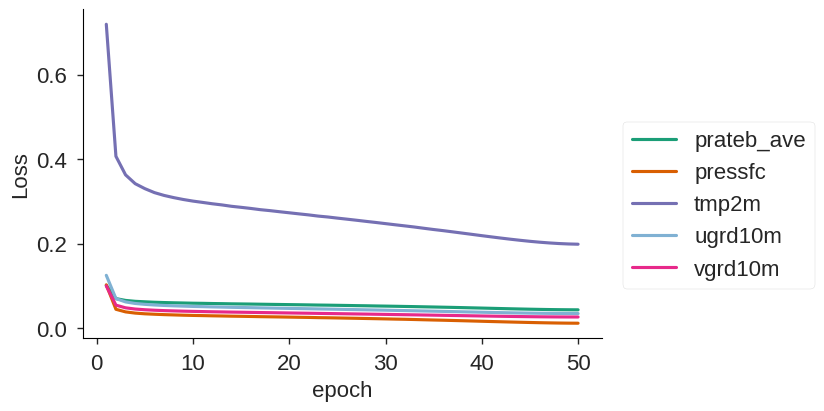

In [62]:
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)

v3d = [k for k in vds.data_vars if k not in ["pressfc", "tmp2m", "ugrd10m", "vgrd10m", "prateb_ave"]]
v2d = [k for k in vds.data_vars if k in ["pressfc", "tmp2m", "ugrd10m", "vgrd10m", "prateb_ave"]]

for key in v2d:
    plotme = vds[key].copy()
    plotme.plot.line(
        ax=ax,
        label=key,
    )
fig.legend(bbox_to_anchor=(1.01, .5), loc="center left")
ax.set(ylabel="Loss")

In [22]:
def calc_params_norm(id):
    ckpt_path = f"results/v1/models/model_{id}.npz"
    with open(ckpt_path, "rb") as f:
        ckpt = checkpoint.load(f, graphcast.CheckPoint)
    mean_abs = np.mean(
        jax.tree_util.tree_flatten(
            jax.tree_util.tree_map(
                lambda x: np.abs(x).mean(), params
            )
        )
    )
    return ckpt.params

In [23]:
models = list(
    load_checkpoint(i)
    for i in range(51)
)

MemoryError: Unable to allocate 3.00 MiB for an array with shape (786432,) and data type float32

In [ ]:
grads = list(
    np.mean(
        jax.tree_util.tree_map(lambda x: 

Loss per channel averaged over last epoch

<BarContainer object of 83 artists>

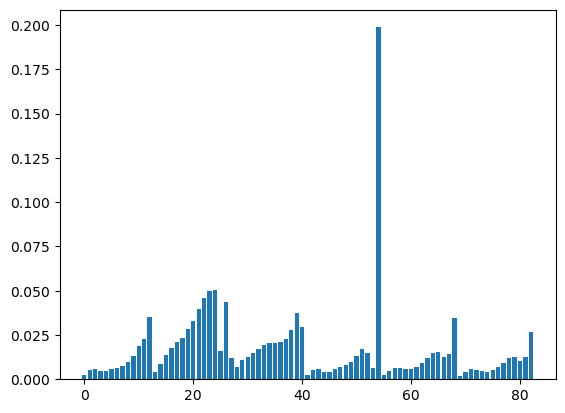

In [15]:
plt.bar(ds.channels, ds.loss_by_channel.where(ds.epoch_label.astype(int) == 50).mean("optim_step"))

In [ ]:
ds0 = xr.load_dataset("results/v0/loss.nc")

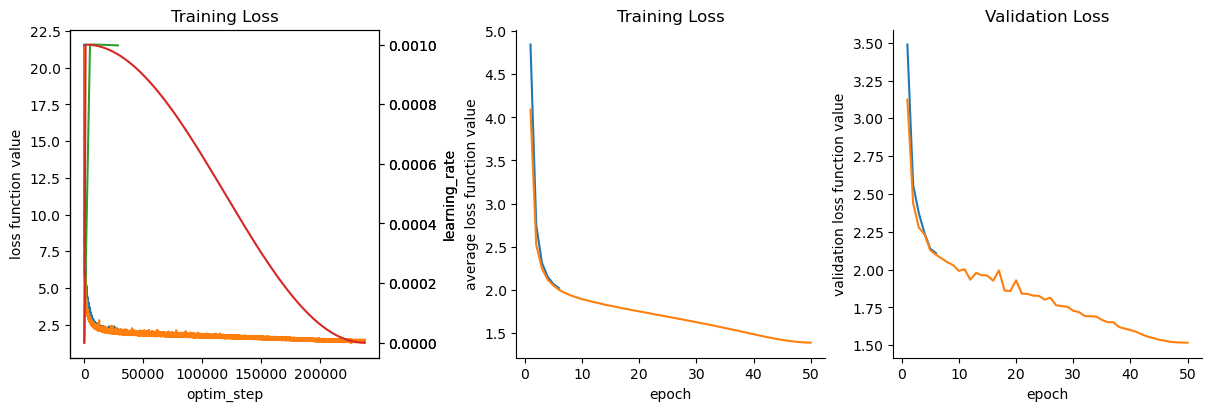

In [4]:
fig, axs = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)

idx = 0
for xds in [ds0, ds]:
    xds.loss.plot(ax=axs[0])
    axLR = axs[0].twinx()
    l2 = xds.learning_rate.plot(ax=axLR, color=f"C{idx+2}", label="Learning Rate")
    idx+=1
    xds.loss_avg.plot(ax=axs[1])
    xds.loss_valid.plot(ax=axs[2])

for ax, mode in zip(axs, ["Training", "Training", "Validation"]):
    #ax.text(.5, .8, f"{mode} Loss", transform=ax.transAxes)
    ax.set(title=f"{mode} Loss")

for ax in axs:
    for key in ["top", "right"]:
        ax.spines[key].set_visible(False)

The difference between blue and orange is just the LR schedule.
* Blue (v0): 1 epoch (4748 steps) linear ramp up, 149 epochs cosine decay. So basically no decay over these 6 epochs (green = v0 LR)
* Orange (v1): 1000 steps linear ramp up, 50 epochs cosine decay, start to see some decay by epoch 10 (red = v1 LR).

TL;DR 150 epochs was way too aggressive